In [1]:
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

def f_bits2array(bits):
  return [b*2**p for p,b in enumerate(np.flip(bits)) if b!=0]

def f_class_weights(yy):
  yy_labels,yy_counts = np.unique(yy,return_counts=True,axis=0)
  cc_weights = {i:0 for i in range(np.max(yy.ravel())+1)}
  yy_weights = len(yy)/(len(yy_labels)*yy_counts)
  cc_weights.update({yy_labels[i][0]:yy_weights[i] for i,l in enumerate(yy_labels)})
  return cc_weights

def f_savefig(gname,gmetadata,gshow=False):
  plt.savefig(gname,dpi=plt.rcParams["figure.dpi"],metadata=gmetadata,bbox_inches="tight",pad_inches=.2)
  if gshow: plt.show()
  plt.close()  

In [2]:
fpath = os.path.join(os.getcwd(),"data")
fprefix = "aug.0k"
fversion = "1"
fname = os.path.join(fpath,"data.1.%s.npz"%(fprefix))

fresult = os.path.join(os.getcwd(),"model","wisa.net.%s.%s"%(fprefix,fversion))

print("result:",fresult)

fmetadata = {"Title":fprefix,"Creation Time":datetime.datetime.now().strftime("%d.%m.%Y %H:%M:%S")}

data = np.load(fname)

X = data['arr_0']
y = data['arr_1']

# small anomaly removal
X[X==3] = 2

X_raw = X.copy()
y_raw = y.copy()

types = np.arange(y.sum(axis=1).max()+1)
y = np.packbits(y,axis=1)

y_index = {n:i for i,n in enumerate(np.unique(y))}
y = np.array([[y_index[n]] for n in y.flatten()])

label_index = {y_index[k]:k for k in y_index.keys()}

labels,counts = np.unique(y,return_counts=True,axis=0)
c_weights = f_class_weights(y)

result: c:\Users\norma\Desktop\Develop\vsc\wisa\develop\model\wisa.net.aug.0k.1


In [3]:
assemblies = []
for t in types:    
  ll = np.unique(y_raw[np.where(y_raw.sum(axis=1)==t)[0]],axis=0)  
  for l in ll:    
    index = np.argwhere(np.packbits(y_raw,axis=1)==np.packbits(l))[:,0]
    assemblies.append(
      dict(
        type=t,label=l,
        number=np.packbits(l)[0],
        number_index=y_index[np.packbits(l)[0]],
        index=index,
        assembly=f_bits2array(l),
        bin=len(index)
      ))

assemblies = pd.DataFrame(assemblies)
assemblies = assemblies.sort_values(by=["type","number"])

print(assemblies.loc[:,~assemblies.columns.isin(["index"])].to_markdown())

|    |   type | label             |   number |   number_index | assembly        |   bin |
|---:|-------:|:------------------|---------:|---------------:|:----------------|------:|
|  0 |      0 | [0 0 0 0 0 0 0 0] |        0 |              0 | []              |  1000 |
|  1 |      1 | [0 0 0 0 0 0 0 1] |        1 |              1 | [1]             |   866 |
|  2 |      1 | [0 0 0 0 0 0 1 0] |        2 |              2 | [2]             |  1000 |
|  3 |      1 | [0 0 0 0 0 1 0 0] |        4 |              3 | [4]             |   149 |
|  4 |      1 | [0 0 0 0 1 0 0 0] |        8 |              4 | [8]             |  1000 |
|  5 |      1 | [0 0 0 1 0 0 0 0] |       16 |              6 | [16]            |  1000 |
|  6 |      1 | [0 0 1 0 0 0 0 0] |       32 |             10 | [32]            |  1000 |
|  7 |      1 | [0 1 0 0 0 0 0 0] |       64 |             14 | [64]            |  1000 |
|  8 |      1 | [1 0 0 0 0 0 0 0] |      128 |             26 | [128]           |  1000 |
|  9 |    

In [4]:
size,w,h = X.shape

X_ = X.astype('float32')
X_ = (X_-X_.min())/(X_.max()-X_.min())

X_train,X_test,y_train,y_test = train_test_split(X_,y,test_size=0.2,random_state=42)
X_test,X_valid,y_test,y_valid = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

X_train = X_train.reshape(X_train.shape[0],w,h,1)
X_test = X_test.reshape(X_test.shape[0], w,h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w,h, 1)

input_shape = (w,h,1)
output_shape = np.max(np.unique(y_train))+1

c_train_weights = f_class_weights(y_train)
c_valid_weights = f_class_weights(y_valid)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_valid = tf.keras.utils.to_categorical(y_valid)

In [5]:
epochs = 25

num_classes = y_train.shape[1]

mtrain = False
mpath = os.path.join(os.getcwd(),"model","wisa.net.%s.%s.%d.h5"%(fprefix,fversion,epochs))

model = tf.keras.models.load_model(mpath,
    custom_objects={
        "f1s":tfa.metrics.F1Score(name="f1s",num_classes=num_classes,average="weighted"),
        "kap":tfa.metrics.CohenKappa(name="kap",num_classes=num_classes)
    }
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv00 (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 pooling00 (MaxPooling2D)    (None, 25, 25, 32)        0         
                                                                 
 conv01 (Conv2D)             (None, 23, 23, 64)        18496     
                                                                 
 pooling01 (MaxPooling2D)    (None, 11, 11, 64)        0         
                                                                 
 flatten00 (Flatten)         (None, 7744)              0         
                                                                 
 upsampling00 (Dense)        (None, 128)               991360    
                                                                 
 dropout00 (Dropout)         (None, 128)               0     

In [6]:
_ = model.evaluate(X_train,y_train,verbose=1)


951/951 [==============================] - 17s 15ms/step - loss: 0.0131 - acc: 0.9962 - auc: 1.0000 - pre: 0.9963 - rec: 0.9962 - f1s: 0.9962 - kap: 0.9961


In [7]:
layer_items = []

for i,layer in enumerate(model.layers):
    name = "%02d: %s"%(i,layer.name)
    if len(layer.weights)>0:
        name = name + " %s %s"%(layer.weights[0].numpy().shape,layer.weights[1].numpy().shape)
        layer_items.append(
            dict(
                weight=layer.weights[0].numpy(),
                bias=layer.weights[1].numpy(),
                name=layer.name
            )
        )
    print(name)
    

00: conv00 (3, 3, 1, 32) (32,)
01: pooling00
02: conv01 (3, 3, 32, 64) (64,)
03: pooling01
04: flatten00
05: upsampling00 (7744, 128) (128,)
06: dropout00
07: output00 (128, 38) (38,)


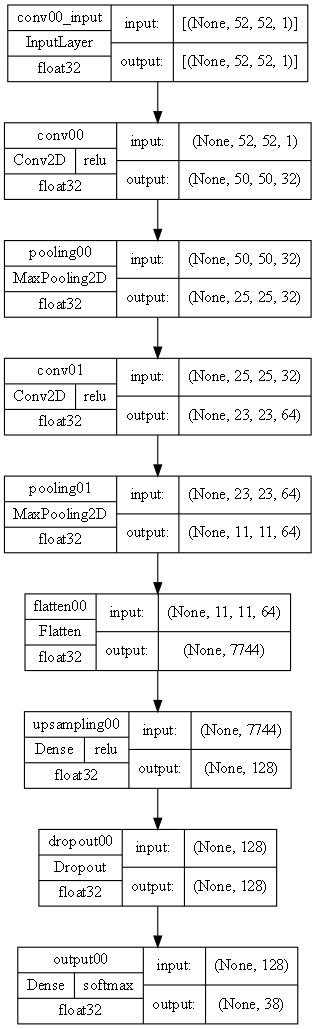

In [8]:
from keras.utils import plot_model

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

plot_model(model,
  show_shapes=True,
  show_dtype=True,
  show_layer_names=True,
  show_layer_activations=True,
  rankdir='TB', # TB: top-bottom, LR: left-right
  dpi=plt.rcParams["figure.dpi"],
  to_file=os.path.join(fresult,"ins","model.full.png")
  )

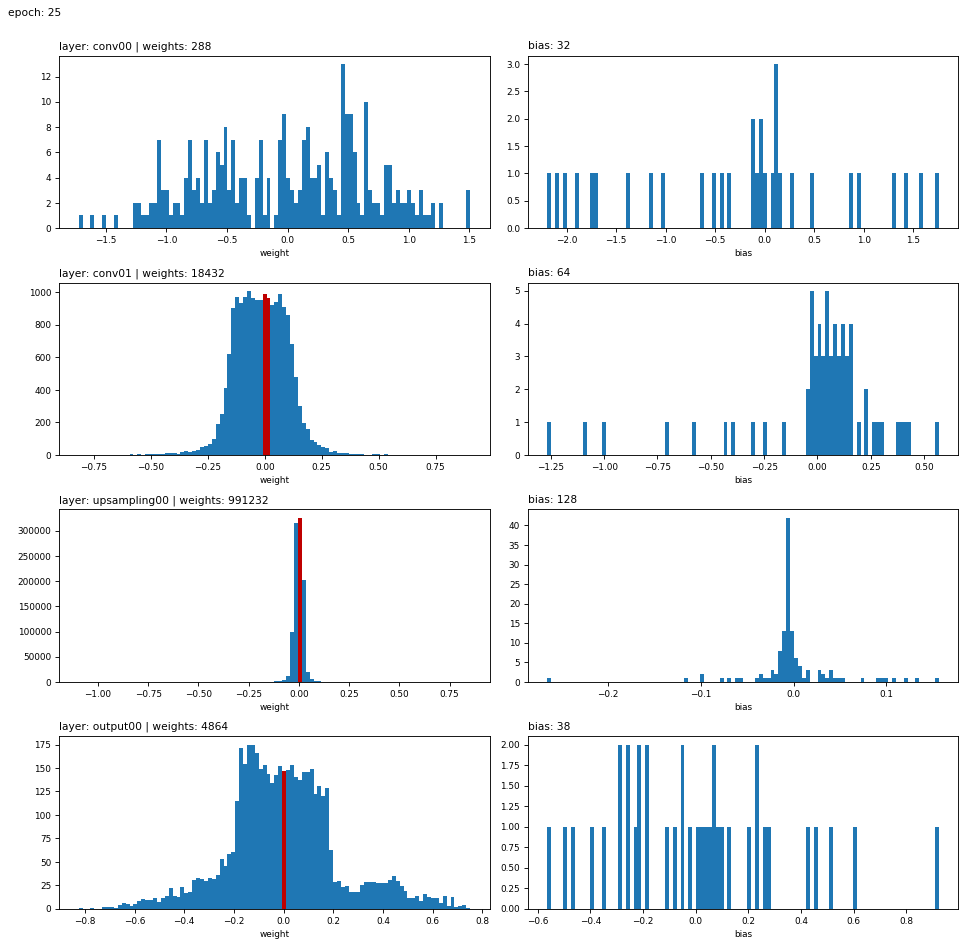

In [10]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

nrows,ncols = len(layer_items),2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[6*ncols,3*nrows],tight_layout=True)
        
bins = 100

for j,item in enumerate(layer_items):
    
    weight = item["weight"].flatten()
    bias = item["bias"].flatten()
    name = item["name"]

    i = 0
    yy,xx,pp = ax[j,i].hist(weight,bins=bins)    
    ax[j,i].set_xlabel("weight")

    ff = yy/yy.max()
    for p,f,x in list(zip(pp,ff,xx)):
        if (x>-0.01) & (x<0.01):        
            p.set_facecolor((192/256,0,0,1))

    i = 1
    yy,xx,pp = ax[j,i].hist(bias,bins=bins)    
    ax[j,i].set_xlabel("bias")

    ax[j,0].set_title("layer: %s | weights: %d"%(name,weight.shape[0]),x=0,ha="left")
    ax[j,1].set_title("bias: %d"%(bias.shape[0]),x=0,ha="left")

plt.suptitle("epoch: %02d\n\n"%(epochs),x=0,ha="left")
plt.tight_layout()
f_savefig(os.path.join(fresult,"ins","layer.weight.png"),fmetadata,gshow=True)

In [11]:
# research layer results

layers = dict([(layer.name,layer) for layer in model.layers])
print("layers available",list(layers.keys()))

# define a test model

keys = ["conv00","pooling00"]

test_model = tf.keras.models.Sequential([],name="test")
for key in keys:
  test_model.add(layers[key])
test_model.compile()

layers available ['conv00', 'pooling00', 'conv01', 'pooling01', 'flatten00', 'upsampling00', 'dropout00', 'output00']


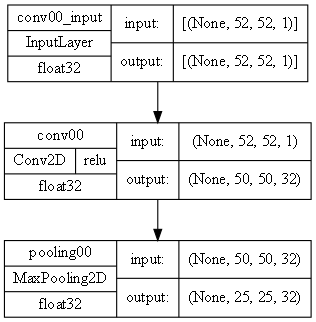

In [12]:
from keras.utils import plot_model

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

plot_model(test_model,
  show_shapes=True,
  show_dtype=True,
  show_layer_names=True,  
  show_layer_activations=True,
  rankdir='TB',
  dpi=plt.rcParams["figure.dpi"],
  to_file=os.path.join(fresult,"ins","model.test.png")
  )

In [13]:
T_pred = test_model.predict(X_)


1188/1188 [==============================] - 10s 8ms/step


In [22]:

n_numbers = [0,1,2,4,8,16,32,64,128]
items = []

n_filters = 0

for n_number in n_numbers:  
  a_indizes = assemblies.loc[assemblies["number"]==n_number,"index"].to_numpy()[0]
  n_index = a_indizes[0]
  F_ = np.zeros((T_pred.shape[1:]))
  for i in range(T_pred.shape[-1]):
    F_[:,:,i] = T_pred[n_index,:,:,i]
  n_filters = F_.shape[2]
  items.append(
    dict(
      number=n_number,
      index=n_index,
      sample=X_[n_index,:,:],
      filter=F_
    )
  )

items = np.array(items)

# -----------------------------

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = len(n_numbers)
nrows = 1 + n_filters
nwidth,nheight = 2,2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows])

for i,item in enumerate(items):

  ax[0,i].imshow(item["sample"],cmap=plt.cm.Blues)
  ax[0,i].set_title("%03d: %s"%(item["number"],item["sample"].shape),x=0,ha="left")

  j = 1
  for k in range(item["filter"].shape[2]):
    
    ax[j,i].imshow(item["filter"][:,:,k],cmap=plt.cm.Reds)
    if 0==k:
      ax[j,i].set_title("%s: %s"%(test_model.layers[-1].name,item["filter"].shape),x=0,ha="left")
    j += 1

for a in ax.ravel():
  a.set_axis_off()

plt.tight_layout()
f_savefig(os.path.join(fresult,"ins","layer.latent.%s.png"%(".".join([layer.name for layer in test_model.layers]))),fmetadata)